In [17]:
import sqlite3
from collections import defaultdict

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

from pygments.lexers import q

In [18]:
db_path = "../instance/database.db"
conn = sqlite3.connect(db_path)

query = "SELECT session_id, attribute, value, source FROM css_attribute"
df = pd.read_sql(query, conn)

conn.close()

In [19]:
# Expected attributes for each session
expected_envs = {f"env-{i}-width" for i in range(1, 15) if i != 4} | {f"env-{i}-height" for i in range(1, 15) if i != 4}

In [20]:
# Filter sessions that have at least one browserstack attribute
browserstack_sessions = df[df['source'] == 'browserstack']['session_id'].unique()
filtered_df = df[df['session_id'].isin(browserstack_sessions)]

In [21]:
# Group by session and check missing attributes
missing_data = {}
os_mistakes_count = defaultdict(int)
os_browser_combinations = defaultdict(set)

for session, group in filtered_df.groupby('session_id'):
    attributes = set(group['attribute'])
    missing_attrs = expected_envs - attributes
    if missing_attrs:
        # Extract OS, OS Version, Browser, and Browser Version
        os_value = group[group['attribute'] == 'os']["value"].values[0] if not group[group['attribute'] == 'os'].empty else "Unknown"
        os_version = group[group['attribute'] == 'os_version']["value"].values[0] if not group[group['attribute'] == 'os_version'].empty else "Unknown"
        browser = group[group['attribute'] == 'browser']["value"].values[0] if not group[group['attribute'] == 'browser'].empty else "Unknown"
        browser_version = group[group['attribute'] == 'browser_version']["value"].values[0] if not group[group['attribute'] == 'browser_version'].empty else "Unknown"

        os_mistakes_count[os_value] += 1
        os_browser_combinations[(os_value, os_version, browser, browser_version)].add(session)

        missing_data[session] = {
            "missing": list(missing_attrs),
            "browserstack_data": group[group['source'] == 'browserstack'].to_dict(orient='records')
        }

In [22]:
# Display missing data
for session, details in missing_data.items():
    print(f"Session ID: {session}")
    print("Missing Attributes:", details["missing"])
    print("BrowserStack Data:", details["browserstack_data"])
    print("-" * 50)

Session ID: 00373a31-f65d-45af-a25c-9e08e82c9f98
Missing Attributes: ['env-13-height', 'env-1-width', 'env-9-height', 'env-1-height', 'env-2-height', 'env-10-height', 'env-14-width', 'env-3-width', 'env-2-width', 'env-12-width', 'env-10-width', 'env-6-height', 'env-11-height', 'env-12-height', 'env-6-width', 'env-9-width', 'env-8-height', 'env-7-width', 'env-14-height', 'env-11-width', 'env-13-width', 'env-3-height', 'env-7-height', 'env-5-width', 'env-8-width', 'env-5-height']
BrowserStack Data: [{'session_id': '00373a31-f65d-45af-a25c-9e08e82c9f98', 'attribute': 'browser', 'value': 'firefox', 'source': 'browserstack'}, {'session_id': '00373a31-f65d-45af-a25c-9e08e82c9f98', 'attribute': 'browser_version', 'value': '101.0', 'source': 'browserstack'}, {'session_id': '00373a31-f65d-45af-a25c-9e08e82c9f98', 'attribute': 'os', 'value': 'OS X', 'source': 'browserstack'}, {'session_id': '00373a31-f65d-45af-a25c-9e08e82c9f98', 'attribute': 'os_version', 'value': 'Big Sur', 'source': 'browsers

In [23]:
# Display OS and Browser statistics
print("\nSummary of OS Mistakes:")
for os_value, count in os_mistakes_count.items():
    print(f"{os_value}: {count} mistakes")


Summary of OS Mistakes:
OS X: 205 mistakes
Windows: 76 mistakes
ios: 23 mistakes
android: 27 mistakes
Unknown: 1 mistakes


In [24]:
print("\nOS, OS Version, Browser, and Browser Version combinations with issues:")
for (os_value, os_version, browser, browser_version), sessions in os_browser_combinations.items():
    print(f"OS: {os_value}, OS Version: {os_version}, Browser: {browser}, Browser Version: {browser_version}, Affected Sessions: {len(sessions)}")


OS, OS Version, Browser, and Browser Version combinations with issues:
OS: OS X, OS Version: Big Sur, Browser: firefox, Browser Version: 101.0, Affected Sessions: 1
OS: OS X, OS Version: Sonoma, Browser: chrome, Browser Version: 108.0, Affected Sessions: 1
OS: OS X, OS Version: High Sierra, Browser: chrome, Browser Version: 107.0, Affected Sessions: 1
OS: Windows, OS Version: 10, Browser: chrome, Browser Version: 118.0, Affected Sessions: 2
OS: OS X, OS Version: High Sierra, Browser: chrome, Browser Version: 103.0, Affected Sessions: 1
OS: ios, OS Version: 17.5, Browser: chrome, Browser Version: unknown, Affected Sessions: 3
OS: android, OS Version: 11.0, Browser: chrome, Browser Version: unknown, Affected Sessions: 9
OS: ios, OS Version: 17.3, Browser: chrome, Browser Version: unknown, Affected Sessions: 2
OS: OS X, OS Version: Ventura, Browser: chrome, Browser Version: 100.0, Affected Sessions: 1
OS: OS X, OS Version: Monterey, Browser: chrome, Browser Version: 116.0, Affected Sessi

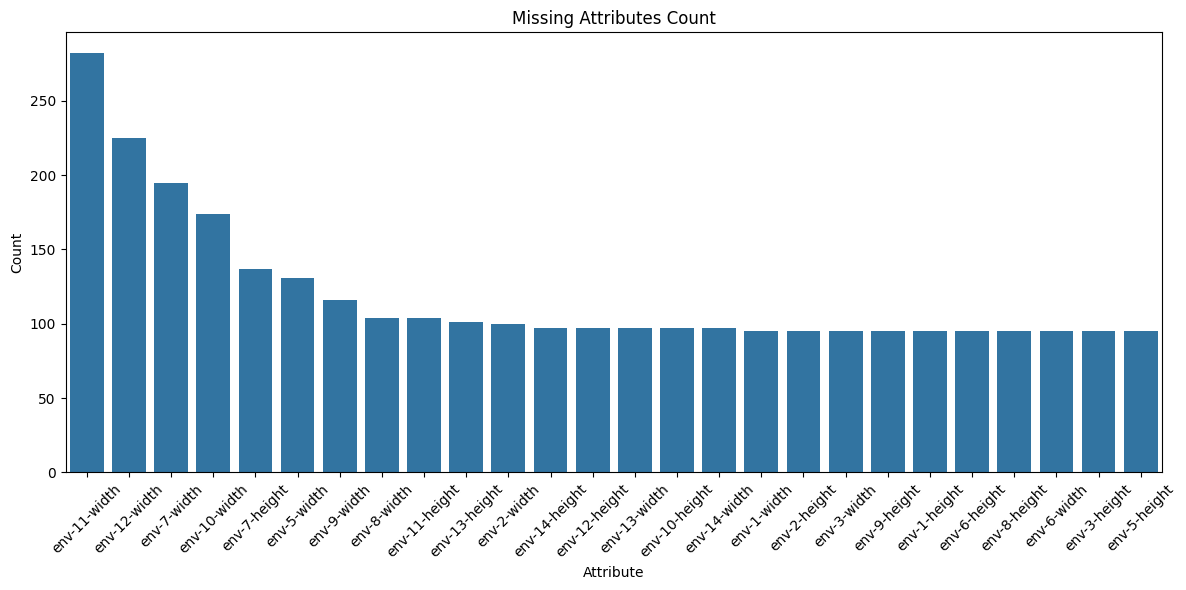

In [33]:
# from missing_data create a histogram of missing attributes
missing_counts = Counter()
for details in missing_data.values():
    for attr in details["missing"]:
        missing_counts[attr] += 1
# Create a DataFrame for plotting
missing_df = pd.DataFrame(missing_counts.items(), columns=['Attribute', 'Count'])
# Sort the DataFrame by Count
missing_df = missing_df.sort_values(by='Count', ascending=False)
# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=missing_df, x='Attribute', y='Count')
plt.xticks(rotation=45)
plt.title('Missing Attributes Count')
plt.xlabel('Attribute')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


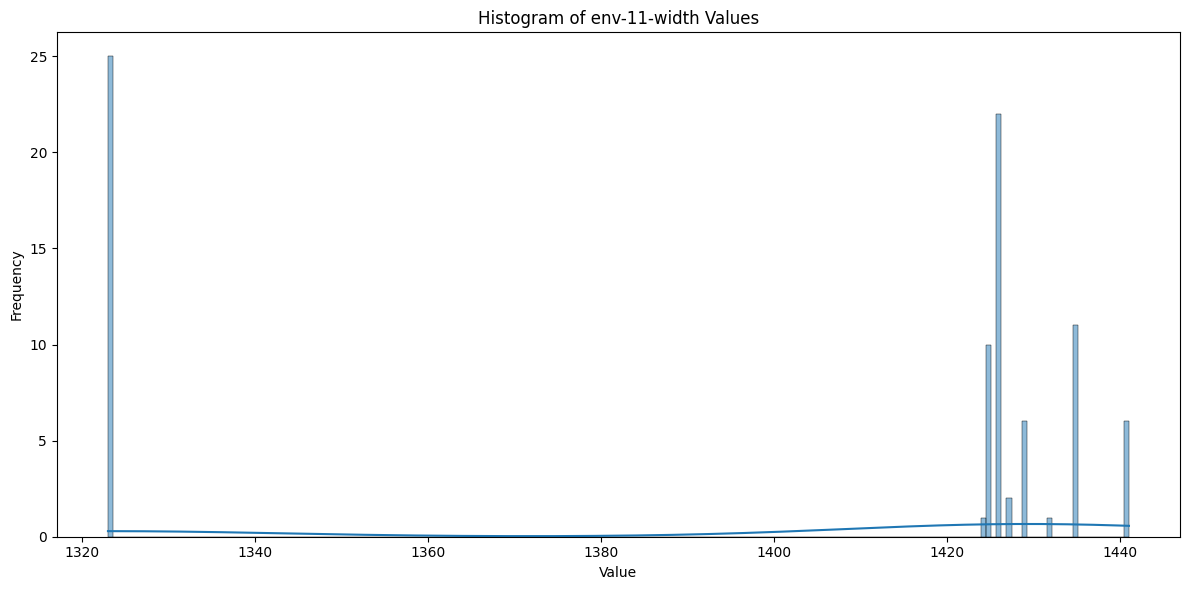

In [39]:
# query the database and plot the histogram of values for env-11-width
conn = sqlite3.connect(db_path)
query = "SELECT session_id, value FROM css_attribute WHERE attribute = 'env-11-width'"
df_env_11_width = pd.read_sql(query, conn)
conn.close()
# get data only from unique session_id
df_env_11_width = df_env_11_width.drop_duplicates(subset=['session_id'])
# Convert the values to numeric, ignoring errors
df_env_11_width['value'] = pd.to_numeric(df_env_11_width['value'], errors='coerce')
# Drop NaN values
df_env_11_width = df_env_11_width.dropna()
# Plotting
plt.figure(figsize=(12, 6))
sns.histplot(df_env_11_width['value'], bins=200, kde=True)
plt.title('Histogram of env-11-width Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [52]:
# write a sql query that will get all of the session_ids that don't have a record for env-11-width
conn = sqlite3.connect(db_path)
query = """
SELECT DISTINCT session_id, attribute, value
FROM css_attribute
WHERE session_id NOT IN (
    SELECT DISTINCT session_id
    FROM css_attribute
    WHERE attribute = 'env-11-width'
)
"""
missing_session_ids = pd.read_sql(query, conn)
conn.close()
# remove attributes that are not os, os_version, browser, browser_version
missing_session_ids = missing_session_ids[missing_session_ids['attribute'].isin(['os', 'os_version', 'browser', 'browser_version'])]

# for each session_id get the values of os, os_version, browser, browser_version
missing_session_ids = missing_session_ids.groupby('session_id').agg(lambda x: ', '.join(x)).reset_index()
missing_session_ids


,session_id,attribute,value
0,00373a31-f65d-45af-a25c-9e08e82c9f98,"browser, browser_version, os, os_version","firefox, 101.0, OS X, Big Sur"
1,00c3ac8d-b1c7-40e1-b805-4fba76d5c662,"browser, browser, browser_version, os, os_version","chrome, edge, 108.0, OS X, Sonoma"
2,0121c5b4-c506-4f5d-9bb7-169d004cd9cd,"browser, browser, browser_version, os, os_version","chrome, edge, 107.0, OS X, High Sierra"
3,02124455-c02e-45c2-8325-f716997d4326,browser,chrome
4,02596087-adf8-46b4-8c59-2ddfa0512cb3,"browser, browser, browser_version, os, os_version","chrome, edge, 118.0, Windows, 10"
...,...,...,...
304,fc9ec897-c425-4ad8-8b3c-a830ef853726,"browser, browser_version, os, os_version","chrome, 134.0, OS X, Big Sur"
305,fcc415d7-5bfc-46c5-a82f-ab743fa58c0c,"browser, browser_version, os, os_version","chrome, 101.0, OS X, Sequoia"
306,fdb57077-b6f0-4451-9ec0-33d00d9f16cc,"browser, browser_version, os, os_version","firefox, 83.0, Windows, 8.1"
307,fe47faab-ca84-4869-8a81-fdde38012093,"browser, browser_version, os, os_version","firefox, 113.0, Windows, 7"
